# Visualization notebook

This notebook is meant for visualizing stuff and testing code. 

In [7]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import json
from nltk import Tree
from spacy import displacy
import spacy
from more_itertools import chunked
from dataclasses import dataclass
from nltk.tokenize import word_tokenize
from collections import defaultdict, Counter
from featurizers import GrammarVectorizer, make_document
from typing import List, Dict, Tuple, Set
warnings.filterwarnings("ignore", category=FutureWarning)

# PAN 2022 Summary Stats & Visualizations


In [8]:
@dataclass
class Author:
    """
    Stores author information in an easy to work with format
    
    :param author_id: unique author id
    :param fixed_texts: list of author documents with regex fixes
    :param raw_texts: list of author documents without regex fixes
    :param discourse_types: list of discourse types
    
    Note: fixed_docs, raw_docs, and discourse_types are all 1 - 1 corresponding
    """
    author_id:str
    fixed_texts:list[str]
    raw_texts:list[str]
    discourse_types:list[str]
    
    def get_token_counts(self) -> list[int]:
        return [len(word_tokenize(author_doc)) for author_doc in self.fixed_texts]
    
    def get_total_docs(self) -> int:
        return len(self.fixed_texts)
    
    def count_dicourse_type(self, dtype:str) -> int:
        return Counter(self.discourse_types)[dtype]
        
def load_json(path:str) -> dict[str, list[dict]]:
    with open(path, "r") as fin:
        data = json.load(fin)
        return data

def extract_from_dict(author_entry:dict, to_extract:str) -> list[str]:
    return [entry[to_extract] for entry in author_entry]
    
def create_author_list(preprocessed_data:dict[str, list[dict]]) -> list[Author]:
    """
    Converts the preprocessed data into a list of Author objects
    """
    authors = []
    for author_id in preprocessed_data.keys():
        author_entry = preprocessed_data[author_id]
        fixed_texts = extract_from_dict(author_entry,"fixed_text")
        raw_texts = extract_from_dict(author_entry,"raw_text")
        discourse_types = extract_from_dict(author_entry,"discourse_type")
            
        authors.append(Author(author_id, fixed_texts, raw_texts, discourse_types))
        
    return authors

def get_doc_token_stats(authors:list[Author]) -> tuple[float, float]:
    """Gets the mean and std of tokens per document"""
    all_doc_token_counts = []
    for author in authors:
        all_doc_token_counts.extend(author.get_token_counts())
    return np.mean(all_doc_token_counts), np.std(all_doc_token_counts)
    
def make_author_df(authors:list[Author]) -> pd.DataFrame:
    
    author_maps = defaultdict(list)
    for author in authors:
        author_maps["author_id"].append(author.author_id)
        author_maps["total_token_count"].append(sum(author.get_token_counts()))
        author_maps["Total docs"].append(author.get_total_docs())
        author_maps["Emails"].append(author.count_dicourse_type("email"))
        author_maps["Memos"].append(author.count_dicourse_type("memo"))
        author_maps["Txt msgs"].append(author.count_dicourse_type("text_message"))
        author_maps["Essays"].append(author.count_dicourse_type("essay"))
        
    return pd.DataFrame(author_maps)

data = load_json("data/pan22/preprocessed/author_doc_mappings.json")
all_authors = create_author_list(data)
df = make_author_df(all_authors)

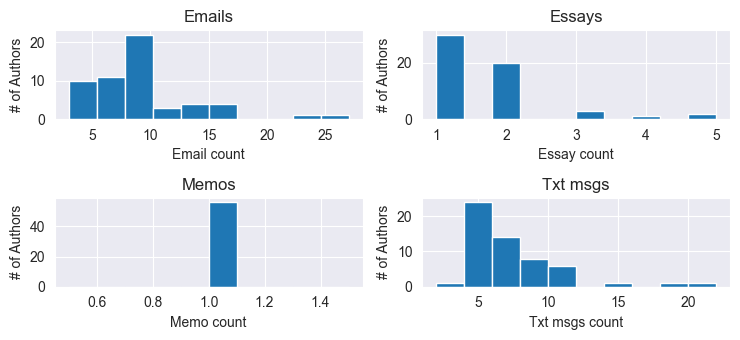

In [76]:


fig, axes = plt.subplots(2,2)


axes[0,0].hist(df['Emails'])
axes[0,0].set_title("Emails")
axes[0,0].set_xlabel("Email count")
axes[0,0].set_ylabel("# of Authors")

axes[0,1].hist(df['Essays'], )
axes[0,1].set_title("Essays")
axes[0,1].set_xlabel("Essay count")
axes[0,1].set_ylabel("# of Authors")

axes[1,0].hist(df['Memos'])
axes[1,0].set_title("Memos")
axes[1,0].set_xlabel("Memo count")
axes[1,0].set_ylabel("# of Authors")

axes[1,1].hist(df['Txt msgs'])
axes[1,1].set_title("Txt msgs")
axes[1,1].set_xlabel("Txt msgs count")
axes[1,1].set_ylabel("# of Authors")



plt.tight_layout()

plt.show()

## Feature testing ground

In [3]:
g2v = GrammarVectorizer()

def get_all_documents(data_path:str, text_type="fixed_text") -> list[str]:
    """Aggregates all documents into one list"""
    all_documents = []
    for author_entries in load_json(data_path).values():
        for entry in author_entries:
            all_documents.append(make_document(entry[text_type], g2v.nlp))
            
    return all_documents

all_documents = get_all_documents("eval/pan22_splits/knn/train.json")

### Syntactic construction featues?

- Look for spacy tree pattern matcher online



In [9]:
sentence = "Apples that fall from trees taste good"
sentence = "Apples that John likes are tasty"
nlp = g2v.nlp
doc = nlp(sentence)

def _to_nltk_tree(node):
    
    _tok_format = lambda tok: "_".join([tok.orth_, tok.pos_,tok.dep_])
    if node.n_lefts + node.n_rights > 0:
        return Tree(_tok_format(node), [_to_nltk_tree(child) for child in node.children])
    else:
        return _tok_format(node)

def get_nltk_tree(doc):
    #https://stackoverflow.com/questions/36610179/how-to-get-the-dependency-tree-with-spacy
    return [_to_nltk_tree(sent.root).pretty_print() for sent in doc.sents]

def get_root(doc) -> spacy.tokens.token.Token:
    return [token for token in doc if token.head == token][0]

def get_subject(root) -> spacy.tokens.token.Token:
    return list(root.lefts)[0]


# root = get_root(doc)
# subject = get_subject(root)

# for descendant in subject.subtree:

#     print(descendant.text, descendant.dep_, descendant.n_lefts,
#             descendant.n_rights,
#             [ancestor.text for ancestor in descendant.ancestors])

get_nltk_tree(doc)



                 are_AUX_ROOT                                   
        ______________|_______________                           
       |                       Apples_NOUN_nsub                 
       |                              j                         
       |                              |                          
       |                       likes_VERB_relcl                 
       |               _______________|________________          
tasty_ADJ_acomp that_PRON_dobj                  John_PROPN_nsubj



[None]

In [5]:
from spacy.matcher import DependencyMatcher
from spacy.pipeline import merge_entities

dobj_relcl = []




### Vocabulary richness vector?

- hapaxes
- \# of mispelled words?
- 

## Visuals

In [ ]:
from data.scripts.pan_create_bins import get_train_authors_sorted_by_docfreq

def bin_authors(iterable) -> tuple[list[str], ...]:
    return tuple(chunked(iterable, 7)) 

def make_doc_avg_labels(sorted_dict):
       
       labels = []
       for bin in bin_authors(list(sorted_dict.values())):
              labels.append(round(np.mean(bin), 2))
       return labels

train_path = "eval/pan22_splits/knn/train.json"
train_authors_sorted = get_train_authors_sorted_by_docfreq(train_path)
labels = make_doc_avg_labels(train_authors_sorted)

# k = 6

r_at_1 = np.array([0.02857142857,0.2285714286,0.1428571429,0.1428571429,0.2285714286,0.1142857143,0.2285714286,0.5142857143])

r_at_8 = np.array([0.2571428571,0.5142857143,0.5142857143,0.5142857143,0.7142857143,0.6857142857,0.7142857143,0.7428571429,])


df = pd.DataFrame({
       "Bin labels": labels,
       "R@1": r_at_1,
       "R@8": r_at_8
})

sns.set_style("darkgrid")


sns.lineplot(data=df, x="Bin labels", y="R@1",color="blue",marker="o", label="R@1")
sns.lineplot(data=df, x="Bin labels", y="R@8",color="green",marker="o", label="R@8")
plt.xlabel("Avg document count")
plt.ylabel("Score")
plt.title("Binned author scores")
plt.legend()

plt.show()

In [ ]:

sns.set_style("darkgrid")
df["Total docs"].hist(bins=7)
plt.title("Document counts per author")
plt.xlabel("# of documents")
plt.ylabel("# of authors")
plt.show()

The following cell contains deprecated information

In [ ]:
ALL_FEATS_ACCS = [0.0, 0.05714285714285714, 0.11428571428571428, 0.17142857142857143, 0.2, 0.2, 0.2857142857142857, 0.5428571428571428]
HALF_FEATS_ACCS = [0.0, 0.02857142857142857, 0.08571428571428572, 0.11428571428571428, 0.22857142857142856, 0.22857142857142856, 0.22857142857142856, 0.4]

old_df = pd.DataFrame(
    {"Full features": ALL_FEATS_ACCS,
     "Half features": HALF_FEATS_ACCS,
     "Bin labels":labels}
)


sns.lineplot(data=old_df, x="Bin labels", y="Full features",color="blue", label="Full features")
sns.lineplot(data=old_df, x="Bin labels", y="Half features", color="red", label="Half features")
plt.xlabel("Avg document count")
plt.ylabel("R@1 score")
plt.title("R@1 Development bin scores")
plt.legend()

plt.show()

# PAN 2022 Discourse related stuff

In [24]:
def load_all_discourse_types(path:str) -> tuple[list,list,list]:
    """Loads the preprocessed data and sorts it by discourse type"""
    preprocessed = load_json(path)
    author_ids = preprocessed.keys()
    emails = []
    memos = []
    txt_msgs = []
    essays = []
    for author_id in author_ids:
        for author_entry in preprocessed[author_id]:
            dtype = author_entry["discourse_type"]
            fixed = author_entry["fixed_text"].split()
            
            if  dtype == "email":
                emails.append(fixed)
                
            if  dtype == "memo":
                memos.append(fixed)
                
            if  dtype == "text_message":
                txt_msgs.append(fixed)
                
            if  dtype == "essay":
                essays.append(fixed)
    return emails, memos, txt_msgs, essays
  
def get_avg_tokens(dtype:list[list[str]]) -> int:
    
    token_counts = []
    for tokens in dtype:
        token_counts.append(len(tokens))
    return np.mean(token_counts)
              
            
emails, memos, txt_msgs, essays = load_all_discourse_types("data/pan22/preprocessed/author_doc_mappings.json")


len(memos)

    

56

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Emails'),
  Text(1, 0, 'Txt msgs'),
  Text(2, 0, 'Essays'),
  Text(3, 0, 'Memos')])

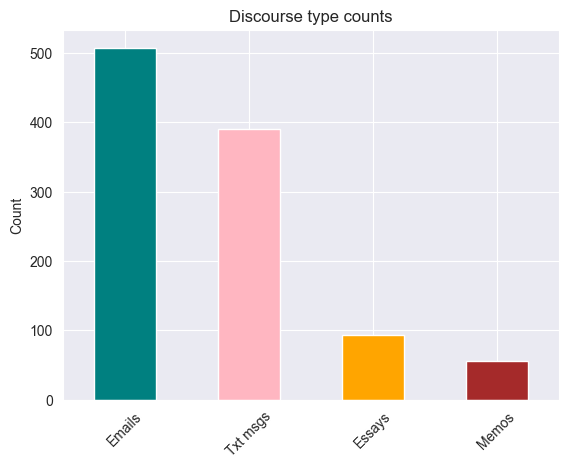

In [18]:
sns.set_style("darkgrid")

dtype_df = df[["Emails", "Txt msgs", "Essays", "Memos"]].sum()
dtype_df.plot.bar(color=["teal", "lightpink", "orange", "brown"])
plt.title("Discourse type counts")
plt.ylabel("Count")
plt.xticks(rotation=45)

plt.show()